# Data And Libraries

## Loading libraries

In [1]:
!pip install keras_tuner tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.0 MB/s 
     |████████████████████████████████| 16.2 MB 217 kB/s 
     |████████████████████████████████| 588.3 MB 17 kB/s 
     |████████████████████████████████| 1.7 MB 48.4 MB/s 
     |████████████████████████████████| 6.0 MB 35.1 MB/s 
     |████████████████████████████████| 439 kB 71.0 MB/s 
     |████████████████████████████████| 1.6 MB 44.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Succe

### Common libraries

In [2]:
#Common libraries
import pandas as pd 
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser as dparser
from google.colab import drive


### Tensor & Keras

In [3]:
#Keras and tensor flow
from numba import jit, cuda
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow.keras import layers
import keras_tuner
from kerastuner import HyperModel
from keras_tuner import Objective
from tensorflow.keras import metrics
from keras_tuner import HyperParameters

<ipython-input-3-d3f525257127>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


### Sklearn

In [4]:
#Sklearn libraries
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from itertools import chain
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import ensemble
import pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from itertools import chain
from sklearn.base import BaseEstimator,TransformerMixin

## Setting some parameters

In [5]:
numeric_feature_names = ['ccs', 'images', 'urls',
       'salutations', 'designation', 'chars_in_subject', 'chars_in_body',
       'hour', 'day', 'week_day', 'week', 'month', 'time_zone_num', "tld_imputed","org_imputed"]
categorical_feature_names = ['org', 'tld', 'mail_type']
binary_feature_names =['bcced']
TARGET_COLUMN_NAME = "label"

##  Transformers

This transformer classes are used with Tensor Keras tune method to tune the hyperparameters

In [6]:
# SVD per group categories
class preprocessing_noEncoding(BaseEstimator,TransformerMixin):
  """"
  This Class is used to transform X, y data to be used with pipeline objects as the ones in sklearn.model.transform
  Params:

  list_sparse_categorical_features:   list of strings
                                      Name of categorical features
  
  """
  def __init__(self,list_sparse_categorical_features):
    self.list_sparse_categorical_features = list_sparse_categorical_features

  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    if set(self.list_sparse_categorical_features).issubset(X.columns):
      # Just in case the label is sent in the data, we create separately the y value
      if 'label' in X.columns:
        y = X['label']
        X = X.drop('label', axis = 1)
      # Feature preprocessing:
      #Transform mail, uppercase and standirdize the list
      X = mail_type_lower_case(X)
      
      #Separate categorical features from the dataset
      df_cat_feature= X[self.list_sparse_categorical_features]
      #Transform categorical features as string #Needed for tensorflow
      df_cat_feature = df_cat_feature.astype("string")
      
      #Apply other simple imputer for categorical features
      cat_imp = SimpleImputer(missing_values="", strategy='constant')
      df_cat_feature = df_cat_feature.fillna(value='').values #fill na values to avoid feat encoder errors
      #Apply the imputer
      df_cat_feature = cat_imp.fit_transform(df_cat_feature)
      
      #Separate the numerical features
      df_numerical_df= X.drop(columns =self.list_sparse_categorical_features)
      # Keep the name of numerical features for rebuilding the entire dataset
      df_numerical_df_colNames = df_numerical_df.columns
      
      #Apply a imputer for na values of numeric features
      df_numerical_df = df_numerical_df.fillna(value=0).values # Fill Na with 0
      
      #Set datatype as float64 for numerical features
      df_numerical_df = df_numerical_df.astype("float64")
      
      #Apply a imputer for numeric features
      num_imp = SimpleImputer(strategy='constant')
      df_numerical = num_imp.fit_transform(df_numerical_df)

      #Normallize numeric features
      scaler = RobustScaler()
      df_numerical = scaler.fit_transform(df_numerical)

      #Join again both categorical and numeric features
      self.df = pd.DataFrame(np.hstack([df_numerical, df_cat_feature]),
      columns=(list(df_numerical_df_colNames) + self.list_sparse_categorical_features ) )

      #Double check data types after nomalization
      self.df[self.list_sparse_categorical_features] = self.df[self.list_sparse_categorical_features].astype("string")
      self.df[list(df_numerical_df_colNames)] = self.df[list(df_numerical_df_colNames)].astype("float64")
    else:
        self.df = X
    return self.df, y

## Functions

Common function used during the assignment

In [7]:

#Processing data

def delete_outlier(df): 
  dataframe = df.copy()
  dataframe = dataframe[dataframe.images < 15000]
  dataframe = dataframe[dataframe.ccs < 2500]

  return dataframe


def date_preprocessing(df): 
  dataframe = df.copy() #so that we don't change the import
  #Extracting hour, months, etc...
  dataframe["date_clean"] = dataframe.date.apply(lambda text : dparser.parse(text,fuzzy=True)) #we extract the date
  dataframe["hour"] = pd.to_datetime(dataframe.date_clean, utc = True).dt.hour
  dataframe["day"] = pd.to_datetime(dataframe.date_clean, utc = True).dt.day
  dataframe["week_day"] = pd.to_datetime(dataframe.date_clean, utc = True).dt.weekday
  dataframe["week"] = pd.to_datetime(dataframe.date_clean, utc = True).dt.isocalendar().week
  dataframe["month"] = pd.to_datetime(dataframe.date_clean, utc = True).dt.month

  #extracting time zone, and converting it into a numerical type
  dataframe["time_zone"]= dataframe.date.str.extract(r'([+-][0-9]*\d\d)').fillna("+0000")
  dataframe["time_zone_num"]=dataframe["time_zone"].apply(lambda a : float(a[0]+str((int(a[1:3]) + float(int(a[3:5])/60.0)))))

  dataframe.drop(["date","date_clean","time_zone"],axis=1,inplace = True)
  return dataframe

def exportPredicted(result_f, name):
  from google.colab import drive
  drive.mount('drive',force_remount=True)
  # np.savetxt("my_tree.csv", result_f, delimiter=",")
  predicted_df = pd.DataFrame(result_f, columns=["label"]).astype("int64")
  predicted_df.index.rename('ID', inplace=True)
  predicted_df.to_csv("predicted.csv")

  !cp predicted.csv "drive/My Drive/Dsba/08 Introduction to Machine Learning/Kaggle/ML-DSBA-Assignment_2_Kaggle/ML-DSBA-Assignment_2_Kaggle/dsba-fm-centralesupelec-ml-course/PredictedData/"

def getStatsFromTuner(tuner_search):
  """
  Function to get the statistics for the model from a tuner object
  """
  best_model = tuner_search.get_best_models()[0]
  _, accuracy = best_model.evaluate(test_dataset, verbose=0)
  print("Best Model:\n")
  print(best_model.summary())
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  
  print("------------------------")
  print("All summary\n")
  print(tuner_search.results_summary())
  return best_model

# Data loading and processing

## Load the data

In [8]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id_train = '1jTnVCQ85Haejd5s_7_8mwSbFcVVvZK9Z'
file_id_test = '1jR4CKjLlXythf3k2EiR6sOWsxFRW-rLK'
downloaded_train = drive.CreateFile({'id': file_id_train})
downloaded_test = drive.CreateFile({'id': file_id_test})

In [9]:
# Load the dataset
# The first two columns contains the exam scores and the third column
# contains the label.
downloaded_train = drive.CreateFile({'id':file_id_train}) 
downloaded_test = drive.CreateFile({'id':file_id_test}) 

downloaded_train.GetContentFile('train.csv') 
downloaded_test.GetContentFile('test.csv')

train_data_without_dates = pd.read_csv('train.csv',index_col=0)
test_data_without_dates = pd.read_csv('test.csv',index_col=0)

Let's do a copy

In [10]:
df_train_without_dates = train_data_without_dates.copy()
df_test_without_dates = test_data_without_dates.copy()

In [11]:
df_train = date_preprocessing(df_train_without_dates)
df_test = date_preprocessing(df_test_without_dates)

# Exploratory Data stage


### Case of dates

Before going further, we need to "preprocess" dates : from a string, we extract relevant information. 

Let's see the range of date, to see which info is important (day, month , year) ? 

In [12]:
print(f"Dates in the training dataset range from {min(df_train_without_dates.date)} to{max(df_train_without_dates.date)} ")
fig = px.histogram(df_train_without_dates, x="date")
fig.show() 

Dates in the training dataset range from 01 Apr 2018 18:50:30 +0530 toWed, 9 Sep 2020 19:00:30 +0000 


In [13]:
fig = px.histogram(df_test_without_dates, x="date")
fig.show()

We preprocess the dates : 
1. We extract the hour of the day, the month, etc.
2. We also extract the time zone, and scale it with 0 as a reference. 

### Case of mail type

We can observe that some instances in mail type are just the same, but with different "cases". We group them. 

In [14]:
def mail_type_lower_case(df): 
  dataframe = df.copy()
  dataframe['mail_type'] = dataframe.mail_type.str.lower().str.replace(' ','')
  mail_type_list = ['multipart/alternative','text/html','multipart/mixed','text/plain','multipart/related']
  dataframe['mail_type'] = dataframe.mail_type.mask(dataframe.mail_type.isin(mail_type_list) != True,'other')
  return dataframe

In [15]:
df_train = mail_type_lower_case(df_train)
df_test = mail_type_lower_case(df_test)

In [16]:
print("Before:\n")
print(df_train_without_dates.mail_type.value_counts())
print("\nAfter:\n")
print(df_train.mail_type.value_counts())

Before:

multipart/alternative    58449
text/html                10224
multipart/mixed           6461
text/plain                2720
multipart/related         1996
text/html                   58
Multipart/Mixed             39
multipart/signed            26
multipart/report            13
Text/Html                   10
text/calendar                4
Multipart/Alternative        3
multipart/IDM                1
Name: mail_type, dtype: int64

After:

multipart/alternative    58452
text/html                10292
multipart/mixed           6500
text/plain                2720
multipart/related         1996
other                      216
Name: mail_type, dtype: int64


We can observe that some instances in mail type are just the same, but with different "cases". We group them

## Basis Checklists : 

### Form analysis

#### 1. Variable target : **label** 8 different types of emails. 

#### 2. Number of rows and columns :

In [17]:
print(df_train.shape)
print(df_test.shape)

(80176, 18)
(34365, 17)


We can see that we don't respect the "80-20 rule", and even worse : when we will split the data again, we will use even less rows to test on the 30k ones of Kaggle. 

#### 3. Types of the features : We have 3 kind of features 
1. "numerical" that can be categorical (already 1 hot encoded) or continuous, 
2. explicitely categorical (text)

In [18]:
df_train.dtypes.value_counts()

int64      12
object      3
float64     2
UInt32      1
dtype: int64

#### 4. Check the number of missing values : 

In [19]:
(df_train.isna().sum()/df_train.shape[0]*100).sort_values(ascending = False)

tld                 4.306775
org                 4.304281
chars_in_subject    0.019956
bcced               0.000000
mail_type           0.000000
images              0.000000
urls                0.000000
salutations         0.000000
designation         0.000000
ccs                 0.000000
chars_in_body       0.000000
label               0.000000
hour                0.000000
day                 0.000000
week_day            0.000000
week                0.000000
month               0.000000
time_zone_num       0.000000
dtype: float64

We can see that tld **(top-level domain of the sender's organisation)** and org **(organisation of the sender)** have 4% of missing values, so we have to figure out wether we delete these columns or we fill the missing values (on which criteria ?). 

In [20]:
print(f' There are {len(df_train["org"].value_counts())} different values for org.')
print(f' There are {len(df_train["tld"].value_counts())} different values for tld.')

 There are 1038 different values for org.
 There are 291 different values for tld.


Let's see how is the repartition of missing values

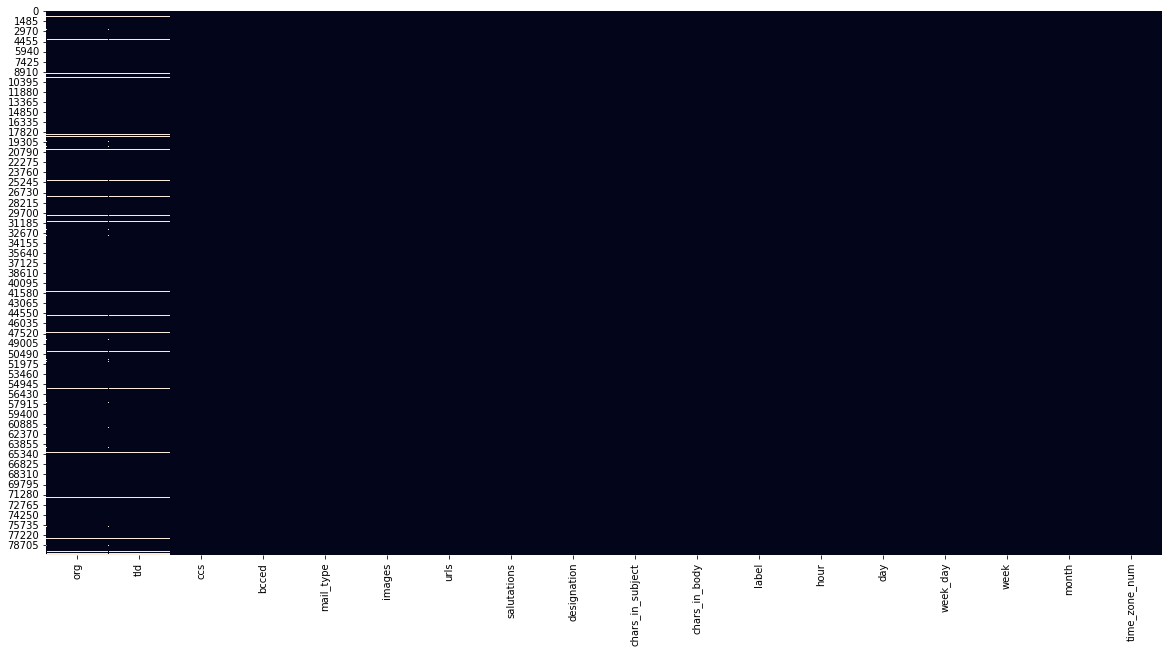

In [21]:
plt.figure(figsize = (20,10))
sns.heatmap(df_train.isna(), cbar = False);

In [22]:
df_train_value_counts = df_train.label.value_counts()/df_train.shape[0]*100
fig = px.pie(df_train_value_counts, values =df_train_value_counts.values, names=df_train_value_counts.index, title='Proportion of labels in the train dataset')
fig.show()


Let's compare the proportion of label in the whole dataset and in the missing org.

In [23]:
df_nan_value_counts = df_train[df_train.org.isna()].label.value_counts()/df_train[df_train.org.isna()].shape[0]*100
fig = px.pie(df_nan_value_counts, values =df_nan_value_counts.values, names=df_nan_value_counts.index, title='Proportion of labels in the nan train dataset')
fig.show()


Conclusion : We can see that the exact same rows are always missing both values. We can try 3 imputation function :**

1. Filling with the most frequent label,
2. Filling with the most frequent label and adding a penalization column,
3. Filling with "unknown" as no information is an information.

As already seen, org and tld are the features with the most missing values. Let's see what is the label associated for those missing values. 

For the whole dataset : 

In [24]:
df_train_value_counts = df_train.label.value_counts()/df_train.shape[0]*100
fig = px.pie(df_train_value_counts, values =df_train_value_counts.values, names=df_train_value_counts.index, title='Proportion of labels in the train dataset')
fig.show()

Only for missing values in org

In [25]:
df_nan_value_counts = df_train[df_train.org.isna()].label.value_counts()/df_train[df_train.org.isna()].shape[0]*100
fig = px.pie(df_nan_value_counts, values =df_nan_value_counts.values, names=df_nan_value_counts.index, title='Proportion of labels in the nan train dataset')
fig.show()

Only for missing values in tld. 

In [26]:
df_train[df_train.tld.isna()].label.value_counts()/df_train[df_train.tld.isna()].shape[0]*100

1    49.203591
0    42.774399
3     4.836374
4     1.390096
5     1.274254
2     0.492326
6     0.028960
Name: label, dtype: float64

**Conclusion : We can see that the exact same rows are always missing both values. We can try 3 imputation function :**

1. Filling with the most frequent label,
2. Filling with the most frequent label and adding a penalization column,
3. Filling with "unknown" as no information is an information.

### Content analysis



#### 1. Vizualisation of the target

In [27]:
df_train["label"].value_counts(normalize = True)*100

1    46.391688
0    22.444372
3    13.379316
2    10.685242
7     6.288665
4     0.445270
6     0.189583
5     0.175863
Name: label, dtype: float64

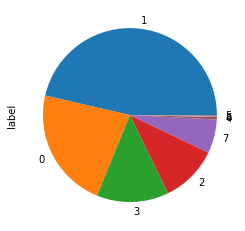

In [28]:
df_train["label"].value_counts().plot.pie();

The most common types of email are 
1. 1 : Personal: Mails from personal network
2. 0 : Updates: Mails from bank, insurance providers, etc
3. 3 : Forums: Mails from professional groups

And one of the most important one, spam (label 6) is one of the lowest. 

#### 2. Histogram of continuous variables

The continuous variables are : 
1. chars_in_subject , 
2. "Chars_in_body"
3. Images 
4. Urls 
5. ccs


In [29]:
for col in ["ccs","images","urls","chars_in_body","chars_in_subject"]: 
  fig = px.histogram(df_train[df_train[str(col)]<200], x=col, color = 'label')
  fig.show()

First, let's plot the explicitely defined continuous variables (float object). 

In [30]:
#import plotly.express as px
fig = px.histogram(df_train[df_train.images<40], x="images", color="label",histnorm='percent')#, barmode  = 'overlay')
fig.show()

In [31]:
for col in df_train.select_dtypes('float'): 
  fig = px.histogram(df_train, x=col, color = 'label')
  fig.show()

Then, let's display the other continuous variables (int64 as type)

In [32]:
for col in ["ccs","images","urls","chars_in_body"]: 
  fig = px.histogram(df_train[df_train[str(col)]<200], x=col, color = 'label')
  fig.show()

#### 3. Categorical variables

We have two kind of categorical features : 
1. Already one hot encoded : bcced,salutations,designation
2. Others : mail_type,org,tld,hour,day, week_day, week, month

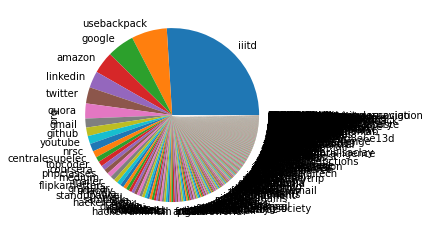

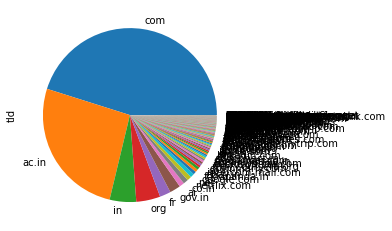

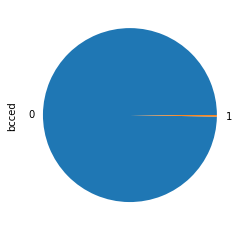

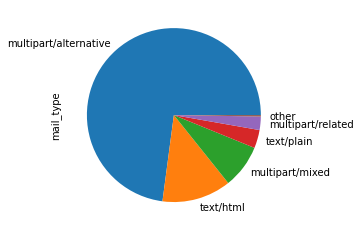

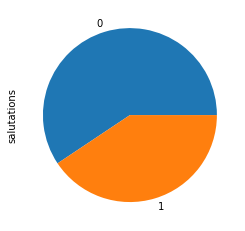

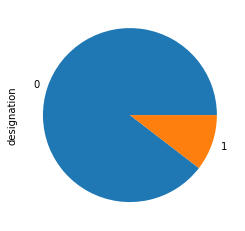

In [33]:
for col in ["org","tld","bcced","mail_type","salutations","designation"]:
  plt.figure()
  df_train[col].value_counts().plot.pie()

Clearly we need to analyse one the one hand org and tld, and on the other hand the binary features. 

#### 4. Relation Feature / Label

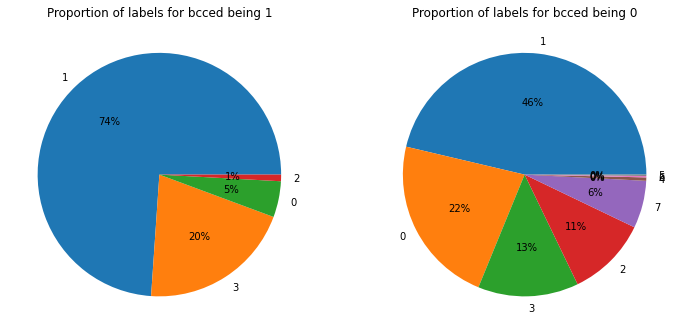

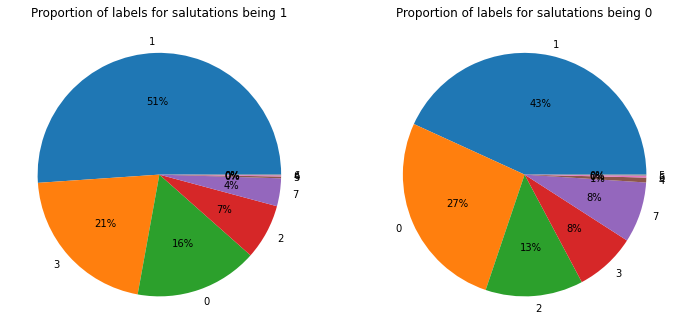

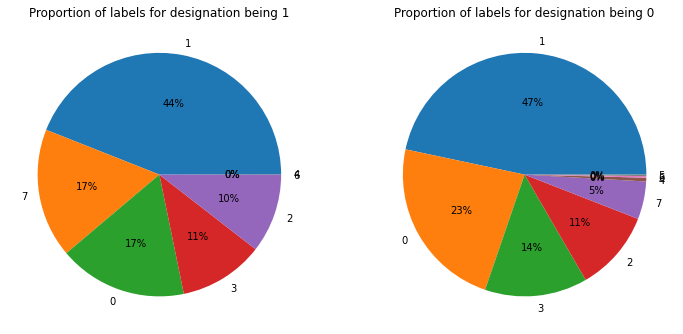

In [34]:
for col in ["bcced","salutations","designation"]:
      fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))
      df_binary_positive = df_train[df_train[str(col)]==1].label.value_counts()
      df_binary_negative = df_train[df_train[str(col)]==0].label.value_counts()     
      ax1.pie(df_binary_positive.values , labels=df_binary_positive.index, 
            autopct='%.0f%%')
      ax1.set_title(f"Proportion of labels for {col} being 1")
      ax2.pie(df_binary_negative.values , labels=df_binary_negative.index,  
            autopct='%.0f%%')
      ax2.set_title(f"Proportion of labels for {col} being 0")
      
      plt.show()

#### 5. Outliers analysis

In [35]:
X_data = df_train.drop('label', axis=1)
numerical_columns = X_data.select_dtypes(['int64', 'float64'])
y = df_train.label

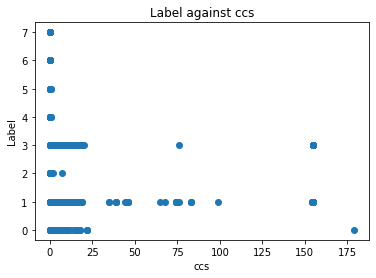

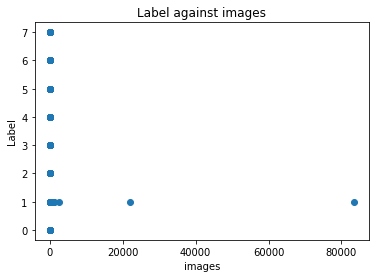

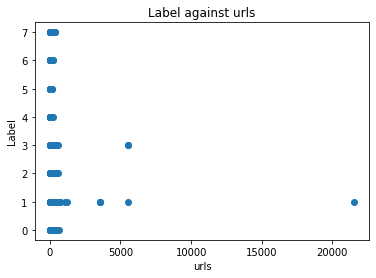

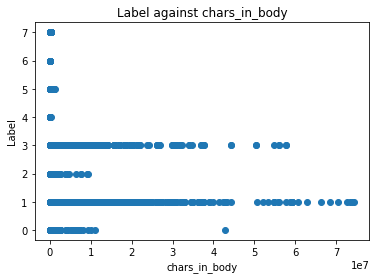

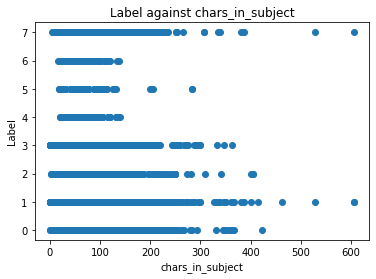

In [36]:
for i in ['ccs', 'images', 'urls', 'chars_in_body', 'chars_in_subject']:
    plt.figure()
    plt.scatter(X_data[i], y)
    plt.xlabel(i)
    plt.ylabel('Label')
    plt.title(f'Label against {i}')
    plt.show()

Observations from the graphs:
- Chars_in_body: We can observe that most values come from label 1 and 3 which corresponds to Personal and Forums. Maybe one outlier in class 0.
- Images: Values very far looks like outliers in class 1.

# Pre-processing 

The methodology is the following 
1. Encoding 
2. Imputation (Dropna) 
3. Train/Test splitting 
4. Transform data to tensors

We need to split what is called "df_train", as we will submit on Kaggle our submission on the real test file. 

## Encoding Non Sparse Columns

For the tensor model, there is not need to use encoding for categorical features as the tensor library already convert it

## Imputation 

We need to handle the na values. 

In [37]:
# Reminder 
(df_train.isna().sum()/df_train.shape[0]*100).sort_values(ascending = False)

tld                 4.306775
org                 4.304281
chars_in_subject    0.019956
bcced               0.000000
mail_type           0.000000
images              0.000000
urls                0.000000
salutations         0.000000
designation         0.000000
ccs                 0.000000
chars_in_body       0.000000
label               0.000000
hour                0.000000
day                 0.000000
week_day            0.000000
week                0.000000
month               0.000000
time_zone_num       0.000000
dtype: float64

In [38]:
def imputation (df, kind = "mode"):
    
    DataFrame = df.copy()
    
    if kind == "mode": 
        
        #1. add new column and replace if category is null then 1 else 0
        DataFrame["tld_imputed"] =   np.where(DataFrame.tld.isnull(),1,0)
        DataFrame["org_imputed"] =   np.where(DataFrame.org.isnull(),1,0)
    
        #2. Take most occured category in that vairable (.mode())
    
        tld_mode = DataFrame.tld.mode()[0]
        org_mode = DataFrame.org.mode()[0]
    
        ##3. Replace NAN values with most occured category in actual vairable
    
        DataFrame.tld.fillna(tld_mode,inplace=True)
        DataFrame.org.fillna(org_mode,inplace=True)
        
    elif kind == "ffill": 
        DataFrame.org.fillna(method = "ffill", inplace = True)
        DataFrame.tld.fillna(method = "ffill", inplace = True)
        
    DataFrame.fillna(DataFrame.mean(), inplace = True) #only chars feature will be filled.
        
    return DataFrame

In [39]:
df_train = imputation(df_train)
df_test = imputation(df_test)

<ipython-input-38-e9dd24705e6b>:25: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



*Remark : replacing the continuous features chars_in_subject by its mean or median doesn't change the accuracy of our model .*

## Preprocess the data

In [40]:
#Create a preprocesing class
pp = preprocessing_noEncoding(categorical_feature_names)
#Apply the preprocesing class to transform the train dataframe
X_processed, y_processed = pp.fit_transform(df_train)

In [41]:
# Preprocess the data to predict
pp = preprocessing_noEncoding(categorical_feature_names)
X_to_predict, y_to_predict = pp.fit_transform(df_test)

## Split the data

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size = 0.3, stratify=y_processed, random_state=1234)


In [43]:
print("Y Train")
print(y_train.value_counts()/y_train.shape[0])
print("Y test")
print(y_test.value_counts()/y_test.shape[0])

Y Train
1    0.463910
0    0.224453
3    0.133795
2    0.106855
7    0.062880
4    0.004455
6    0.001889
5    0.001764
Name: label, dtype: float64
Y test
1    0.463934
0    0.224421
3    0.133788
2    0.106847
7    0.062903
4    0.004449
6    0.001912
5    0.001746
Name: label, dtype: float64


We check if we have the same proportion between trainset and test set for the labels :

For this purpose, we set the stratify option of train split, to have the same proportion of each label

## Transform data to tensors

To work with the tensor flow, it is necessary to transform the data frames to tensorflow data structures, in this case we use pd_dataframe_to_tf_dataset method of tensorflow_decision_forests library. Also, it is important to note that the Label to predict is included into one tensor entity including the feature, but setting the label parameter of the method with the name of the label column, in this case "label"

In [44]:
Test_data_together =pd.concat((X_test,y_test),axis =1)
Train_data_together = pd.concat((X_train,y_train),axis =1)
all_data_together = pd.concat((Train_data_together,Test_data_together), axis = 0)

In [45]:
both_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        all_data_together, label=TARGET_COLUMN_NAME,
    )
train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        pd.concat((X_train,y_train),axis =1), label=TARGET_COLUMN_NAME,
    )
test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
    pd.concat((X_test,y_test),axis =1), label=TARGET_COLUMN_NAME,
)
train_dataset_X = tfdf.keras.pd_dataframe_to_tf_dataset(X_train)

test_dataset_X = tfdf.keras.pd_dataframe_to_tf_dataset(X_test)

# TensorFlow Model

### Setting some fixed hyperparams


This are the hyperparameters found after the tuning process of the random trees

In [46]:
# Maximum number of decision trees.
NUM_TREES = 250
# Minimum number of examples in a node.
MIN_EXAMPLES = 6
# Maximum depth of the tree. max_depth=1 means that all trees will be roots.
MAX_DEPTH = 5
# Ratio of the dataset (sampling without replacement) used to train individual trees for the random sampling method.
SUBSAMPLE = 0.65
# Control the sampling of the datasets used to train individual trees.
SAMPLING_METHOD = "RANDOM"
# Ratio of the training dataset used to monitor the training. Require to be >0 if early stopping is enabled.
VALIDATION_RATIO = 0.1

### Functions to evaluate performance

In [47]:
def run_evaluation(model, train_data, test_data, num_epochs=1, batch_size=None):
    #transform train dataframe from pandas into tensor dataframe
    train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        train_data, label=TARGET_COLUMN_NAME,
    )
    #transform test dataframe from pandas into tensor dataframe
    test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(
        test_data, label=TARGET_COLUMN_NAME,
    )
    # Fit the model
    model.fit(train_dataset, epochs=num_epochs, batch_size=batch_size)
    #Evaluate the accuracy for test data
    _, accuracy = model.evaluate(test_dataset, verbose=0)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [48]:
def set_feature_usages():
  """
  Function to specify the model the type of feature when training
  """
  feature_usages = []

  for feature_name in numeric_feature_names:
      feature_usage = tfdf.keras.FeatureUsage(
          name=feature_name, semantic=tfdf.keras.FeatureSemantic.NUMERICAL
      )
      feature_usages.append(feature_usage)

  for feature_name in categorical_feature_names:
      feature_usage = tfdf.keras.FeatureUsage(
          name=feature_name, semantic=tfdf.keras.FeatureSemantic.CATEGORICAL
      )
      feature_usages.append(feature_usage)

  return feature_usages

### Creating the model

### Model class


In [49]:

class MyGradientTree(HyperModel):
  """
  Class extended from HyperModel, to use in combination with Keras Tune
  """
  def build(self, hp):
    #Setting the hyperparameters we want to go through
    # Maximum depth of the tree. max_depth=1 means that all trees will be roots. Negative values are ignored. Default: 6.
    max_depth = hp.Int("max_depth", min_value=4, max_value=8, step=1)
    #Maximum number of decision trees. The effective number of trained tree can be smaller if early stopping is enabled. Default: 300.
    num_trees = hp.Int("num_trees", min_value=250, max_value=600, step=50)
    #Minimum number of examples in a node. Default: 5.
    min_examples= hp.Int("min_examples", min_value=6, max_value=40, step=10)
    #Ratio of the dataset (sampling without replacement) used to train individual trees for the random sampling method. Default: 1.0.
    subsample= hp.Float("subsample", min_value=0.1, max_value=1, step=0.2)
    # Setting a gradientBoostedTree Model with a combination of hyperparams and the fixed params (Fixed are uppercased)
    model = tfdf.keras.GradientBoostedTreesModel(
        features=set_feature_usages(), #Here is set the feature understanding for the model, which ones are features or numerical
        exclude_non_specified_features=True,
        num_trees=num_trees,
        max_depth=max_depth,
        min_examples=min_examples,
        subsample=subsample,
        validation_ratio=VALIDATION_RATIO,
        task=tfdf.keras.Task.CLASSIFICATION, # Task to performm in this case classification
        loss='MULTINOMIAL_LOG_LIKELIHOOD'
        #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    )
    model.compile(
        metrics=[#if needed we can set the metrics we want to return after fitting the model
                      # tf.keras.metrics.TruePositives(name='tp'),#Other options for metrics to return
                      # tf.keras.metrics.FalsePositives(name='fp'),
                      # tf.keras.metrics.TrueNegatives(name='tn'),
                      # tf.keras.metrics.FalseNegatives(name='fn'),
                      tf.keras.metrics.BinaryAccuracy(name='baccuracy'),
                      #tf.keras.metrics.Accuracy(name='accuracy'),
                      #tf.keras.metrics.Precision(name='precision'),
                      # tf.keras.metrics.Recall(name='recall'),
                      #tf.keras.metrics.AUC(name='auc'),
                      #tf.keras.metrics.CategoricalAccuracy(name='catacc'),
                      #tf.keras.metrics.CategoricalCrossentropy(name='catce')
                      #tf.keras.metrics.SparseCategoricalCrossentropy(name='scatce')
                  ])
    return model
#Another function to create the gradient boosted tree, not compatible with hyperparameter tuning    
def create_gradientBoostTree_model( ):
    """
    Function to create a gradient boost tree model from tensor flow library 
    """
    gbt_model = tfdf.keras.GradientBoostedTreesModel(
        features=set_feature_usages(),
        exclude_non_specified_features=True,
        num_trees=NUM_TREES,
        max_depth=MAX_DEPTH,
        min_examples=MIN_EXAMPLES,
        subsample=SUBSAMPLE,
        validation_ratio=VALIDATION_RATIO,
        task=tfdf.keras.Task.CLASSIFICATION,   
    )

    gbt_model.compile(metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")])
    return gbt_model

### Simple tree fixed parameters

In [50]:
gbt_model = create_gradientBoostTree_model()

Use /tmp/tmpy4ceglno as temporary training directory


In [51]:
gbt_model.fit(train_dataset,epochs=1)

Reading training dataset...


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:05.208569. Found 80176 examples.
Training model...
Model trained in 0:06:26.943850
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [52]:
y = gbt_model.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_to_predict))

35/35 [==============================] - 3s 83ms/step


In [53]:
result_f =np.argmax(y, axis =1)

In [55]:
exportPredicted(result_f, "supertree")

Mounted at drive
